In [1]:
import os
import pandas as pd
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
import numpy as np
from splink.duckdb.duckdb_linker import DuckDBLinker
from splink.duckdb.duckdb_comparison_library import levenshtein_at_thresholds

C:\Users\nicol\AppData\Local\Temp\ipykernel_4416\1215628576.py:6: SplinkDeprecated: Importing directly from `splink.duckdb.duckdb_linker` is deprecated and will be removed in Splink v4. Please import from `splink.duckdb.linker` going forward.
  from splink.duckdb.duckdb_linker import DuckDBLinker
C:\Users\nicol\AppData\Local\Temp\ipykernel_4416\1215628576.py:7: SplinkDeprecated: Importing directly from `splink.duckdb.duckdb_comparison_library` is deprecated and will be removed in Splink v4. Please import from `splink.duckdb.comparison_library` going forward.
  from splink.duckdb.duckdb_comparison_library import levenshtein_at_thresholds


Load the data

In [2]:
STATSBOMB_SHOTS = os.path.join('..', '..', 'data', 'statsbomb', 'shots.parquet')
WYSCOUT_SHOTS = os.path.join('..', '..', 'data', 'wyscout', 'shots.parquet')
FREEZE_FEATURES = os.path.join('..', '..', 'data', 'statsbomb', 'freeze_features.parquet')
df_statsbomb_shots = pd.read_parquet(STATSBOMB_SHOTS)
df_wyscout_shots = pd.read_parquet(WYSCOUT_SHOTS)
df_freeze_frame = pd.read_parquet(FREEZE_FEATURES)

Remove three shots without player info

In [3]:
df_wyscout_shots = df_wyscout_shots[df_wyscout_shots['player_id'].notnull()].copy()

Get a player id by combining the datasets and using a linking algorithm

In [4]:
cols = ['player_id', 'team_id', 'team_name', 'firstName', 'middleName', 'lastName', 'Name', 'country_name', 'competition_gender']
a = (df_wyscout_shots[cols]
     .drop_duplicates('player_id')
     .copy()
    )
a['unique_id'] = 'wyscout' + '-' + a.player_id.astype(str)
a['dataset'] = 'wyscout'
b = (df_statsbomb_shots[cols]
     .drop_duplicates('player_id')
     .copy()
    )
b['unique_id'] = 'statsbomb' + '-' + b.player_id.astype(str)
b['dataset'] = 'statsbomb'
df_duplicates = pd.concat([a, b])

comparison_rules = [
    levenshtein_at_thresholds('firstName', 2),
    levenshtein_at_thresholds('lastName', 2),
    levenshtein_at_thresholds('Name', 2),
    levenshtein_at_thresholds('team_name', 2),
    levenshtein_at_thresholds('country_name', 2),
    ]
settings = {
    'link_type': 'dedupe_only',
    'blocking_rules_to_generate_predictions': [
        'l.firstName = r.firstName',
        'l.lastName = r.lastName',
        'l.team_name = r.team_name',
    ],
    'comparisons': comparison_rules
}
linker = DuckDBLinker(df_duplicates, settings)
linker.estimate_u_using_random_sampling(target_rows=1e6)
linker.estimate_m_from_label_column('firstName')
linker.estimate_m_from_label_column('lastName')
linker.estimate_m_from_label_column('Name')
linker.estimate_m_from_label_column('team_name')
linker.estimate_m_from_label_column('country_name')

pairwise_predictions = linker.predict(threshold_match_probability=0.99)
clusters = linker.cluster_pairwise_predictions_at_threshold(pairwise_predictions, 0.99)
df_clusters = clusters.as_pandas_dataframe()

# where clustered together in same dataset set back to original identifiers
mask_change_cluster = df_clusters.duplicated(['cluster_id', 'dataset'], keep=False)
df_clusters.loc[mask_change_cluster, 'cluster_id'] = df_clusters.loc[mask_change_cluster, 'unique_id']

C:\Users\nicol\AppData\Local\Temp\ipykernel_4416\3547349538.py:33: SplinkDeprecated: target_rows is deprecated; use max_pairs
  linker.estimate_u_using_random_sampling(target_rows=1e6)
----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstName (no m values are trained).
    - lastName (no m values are trained).
    - Name (no m values are trained).
    - team_name (no m values are trained).
    - country_name (no m values are trained).
------- Estimating m probabilities using from column firstName -------
m probability not trained for firstName - Levenshtein <= 2 (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
m probability not trained for firstName - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.

Your model is n

Add unique player id/ Names to datasets

In [5]:
df_cluster_names = df_clusters.drop_duplicates('cluster_id', keep='first')[['cluster_id', 'firstName', 'middleName', 'lastName', 'Name']].copy()

# merge wyscout
df_wyscout_id = df_clusters.loc[df_clusters.dataset == 'wyscout', ['unique_id', 'cluster_id']].copy()
df_wyscout_id['unique_id'] = df_wyscout_id['unique_id'].str.split('-').str[1].astype(float).astype(int)
df_wyscout_id.rename({'unique_id': 'player_id'}, axis='columns', inplace=True)
df_wyscout_shots = (df_wyscout_shots
                    .merge(df_wyscout_id, on='player_id', how='left', validate='m:1')
                    .rename({'player_id': 'player_id_wyscout'}, axis='columns')
                    .drop([ 'firstName', 'middleName', 'lastName', 'Name'], axis='columns')
                    .merge(df_cluster_names, on='cluster_id', how='left', validate='m:1')
                   )

# merge statsbomb
df_statsbomb_id = df_clusters.loc[df_clusters.dataset == 'statsbomb', ['unique_id', 'cluster_id']].copy()
df_statsbomb_id['unique_id'] = df_statsbomb_id['unique_id'].str.split('-').str[1].astype(float).astype(int)
df_statsbomb_id.rename({'unique_id': 'player_id'}, axis='columns', inplace=True)
df_statsbomb_shots = (df_statsbomb_shots
                      .merge(df_statsbomb_id, on='player_id', how='left', validate='m:1')
                      .rename({'player_id': 'player_id_statsbomb'}, axis='columns')
                      .drop([ 'firstName', 'middleName', 'lastName', 'Name'], axis='columns')
                      .merge(df_cluster_names, on='cluster_id', how='left', validate='m:1')
                     )

Merge freeze frame features

In [6]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_freeze_frame, on='id', how='left', validate='1:1')

Concatenate shot datasets

In [7]:
df_statsbomb_shots['dataset'] = 'statsbomb'
df_wyscout_shots.rename({'id': 'wyscout_id'}, axis=1, inplace=True)
df_wyscout_shots['dataset'] = 'wyscout'
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all_shots = pd.concat([df_statsbomb_shots, df_wyscout_shots], axis=0)
df_all_shots.rename({'cluster_id': 'player_id'}, axis='columns', inplace=True)

Pass technique name to 'other' if null

In [8]:
df_all_shots.loc[(df_all_shots.pass_technique_name.isnull()) &
                 (df_all_shots.assist_type == 'pass'), 'pass_technique_name'] = 'other'

Shot heatmap

In [9]:
print('Number of shots:', len(df_all_shots), ';Number of goals:', df_all_shots.goal.sum())

Number of shots: 128727 ;Number of goals: 13084


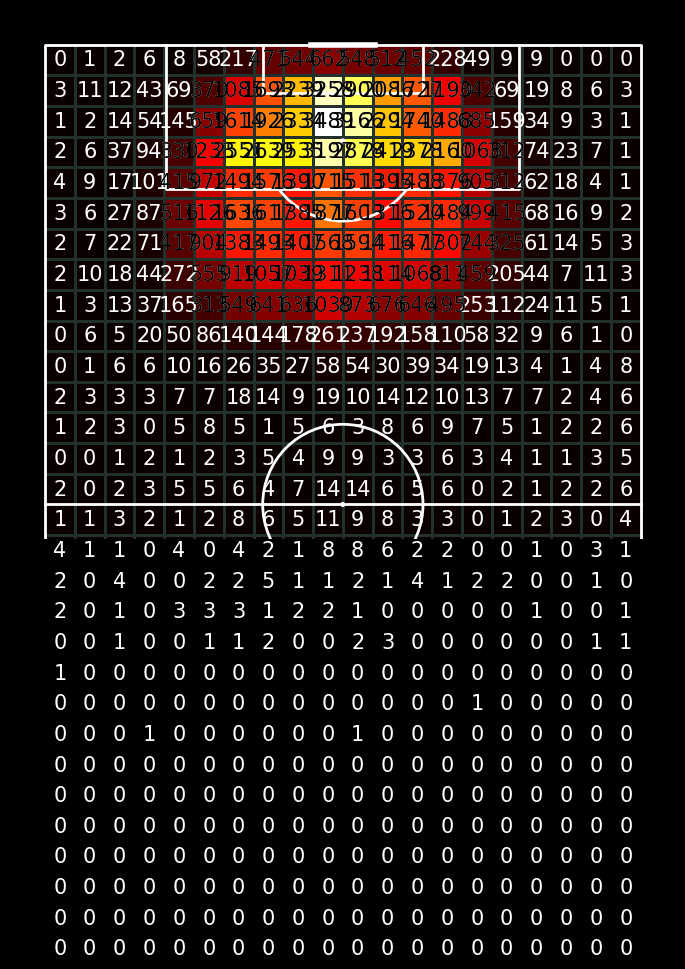

In [10]:
plt.style.use('dark_background')
pitch = VerticalPitch(pitch_type='uefa', half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df_all_shots.x, df_all_shots.y, statistic='count', bins=(30, 20))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = (bs['statistic']).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 300
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join('..', '..', 'figures', '17_number_of_shots_by_location.png'),
            bbox_inches = 'tight', pad_inches = 0.2)

Save dataset

In [11]:
df_all_shots.reset_index(drop=True, inplace=True)

In [12]:
df_all_shots.to_parquet(os.path.join('..', '..', 'data', 'shots.parquet'))

Info

In [13]:
df_all_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128727 entries, 0 to 128726
Data columns (total 49 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   match_id                128727 non-null  int64  
 1   statsbomb_id            85773 non-null   object 
 2   eventSec                128727 non-null  float64
 3   period                  128727 non-null  int64  
 4   goal                    128727 non-null  bool   
 5   team_id                 128727 non-null  int64  
 6   team_name               128727 non-null  object 
 7   player_id_statsbomb     85773 non-null   float64
 8   shot_type_name          128727 non-null  object 
 9   x                       128727 non-null  float64
 10  y                       128727 non-null  float64
 11  counter_attack          128727 non-null  bool   
 12  fast_break              128727 non-null  bool   
 13  strong_foot             128727 non-null  bool   
 14  body_part_name      

Compare datasets

Text(0.5, 1.0, 'Wyscout')

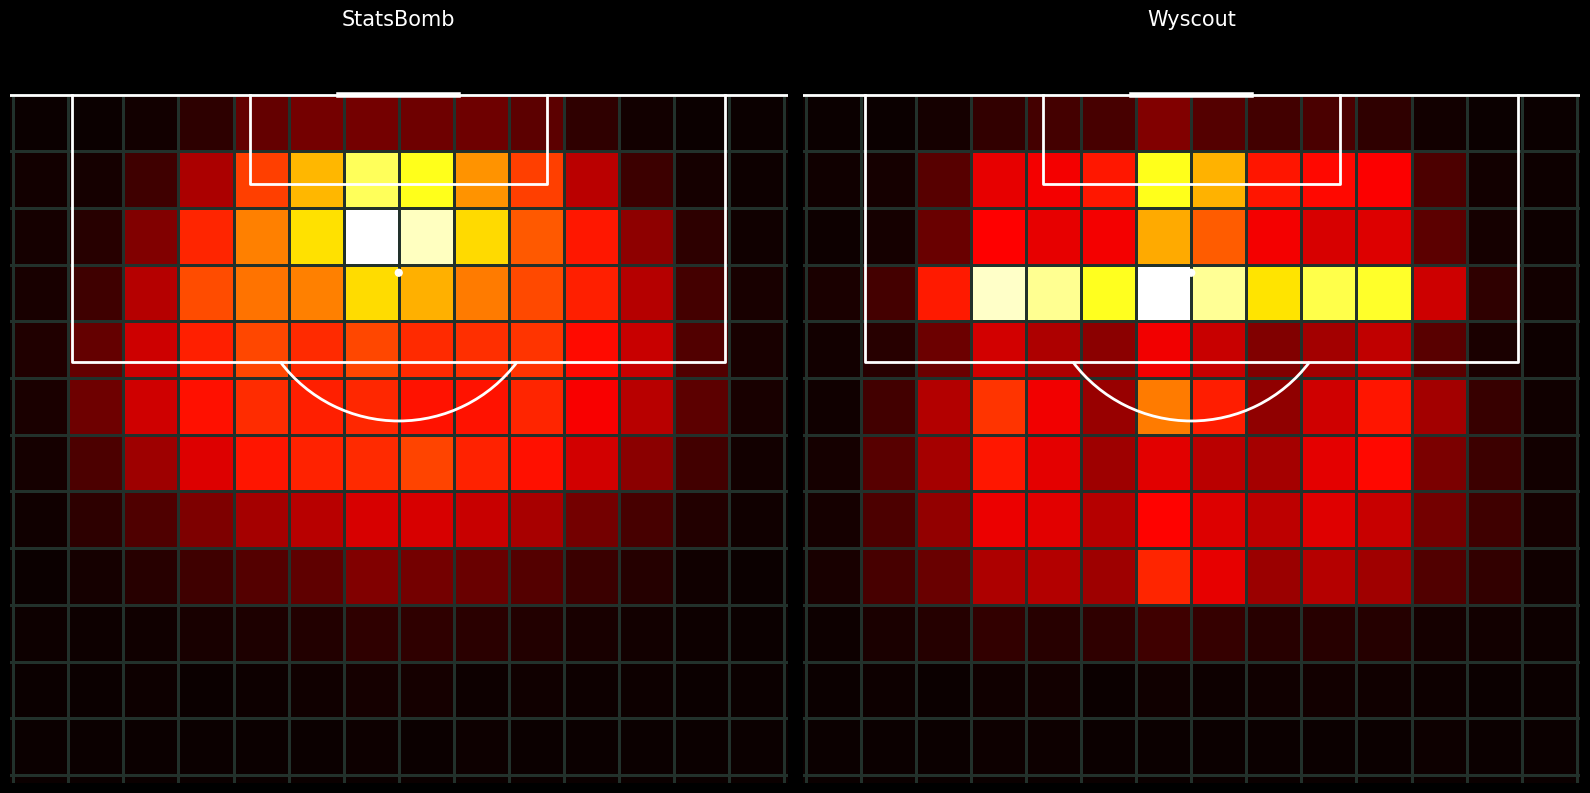

In [14]:
pitch = VerticalPitch(pitch_type='uefa', pad_left=-10, pad_right=-10, pad_bottom=-10,
                      half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12), ncols=2)
ax = ax.ravel()

bs = pitch.bin_statistic(df_all_shots[df_all_shots.dataset=='statsbomb'].x,
                         df_all_shots[df_all_shots.dataset=='statsbomb'].y, 
                         statistic='count', bins=(30, 20))
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[0], cmap='hot', edgecolors='#22312b')
ax[0].set_title('StatsBomb', fontsize=15, pad=-4)

bs = pitch.bin_statistic(df_all_shots[df_all_shots.dataset=='wyscout'].x,
                         df_all_shots[df_all_shots.dataset=='wyscout'].y,
                         statistic='count', bins=(30, 20))
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[1], cmap='hot', edgecolors='#22312b')
ax[1].set_title('Wyscout', fontsize=15, pad=-4)

In [15]:
df_all_shots.groupby('dataset').fast_break.mean()

dataset
statsbomb    0.034125
wyscout      0.043977
Name: fast_break, dtype: float64

In [16]:
df_all_shots.groupby('dataset').counter_attack.mean()

dataset
statsbomb    0.045912
wyscout      0.052382
Name: counter_attack, dtype: float64

In [17]:
df_all_shots.groupby('dataset').visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,85773.0,0.440936,0.275546,0.0,0.263702,0.342365,0.533642,3.141593
wyscout,42954.0,0.413335,0.273950,0.0,0.248669,0.317395,0.488338,3.141593


In [18]:
df_all_shots.groupby('dataset').middle_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,85773.0,0.490899,0.324400,0.0,0.221358,0.455362,0.717917,1.570796
wyscout,42954.0,0.478017,0.320019,0.0,0.218284,0.443925,0.689555,1.570796


In [19]:
df_all_shots.groupby('dataset').distance_to_goal.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,85773.0,17.521753,7.782588,0.4,11.2,17.1,23.200,80.8
wyscout,42954.0,18.884705,8.324751,0.6,12.8,17.7,25.375,75.4


In [20]:
df_all_shots.groupby('dataset').distance_visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,85773.0,6.112443,1.140743,0.0,5.610547,6.468452,6.968982,10.681415
wyscout,42954.0,6.157501,1.131406,0.0,5.691525,6.500222,6.994844,7.313308


In [21]:
df_all_shots.groupby('dataset').pass_switch.value_counts()

dataset    pass_switch
statsbomb  False          57131
           True            4263
wyscout    False          26547
           True            2064
Name: count, dtype: int64

In [22]:
df_all_shots.groupby('dataset').pass_cut_back.value_counts()

dataset    pass_cut_back
statsbomb  False            59805
           True              1589
wyscout    False            27657
           True               954
Name: count, dtype: int64

In [23]:
df_all_shots.groupby('dataset').pass_cross.value_counts()

dataset    pass_cross
statsbomb  False         48920
           True          12474
wyscout    False         21300
           True           7311
Name: count, dtype: int64

In [24]:
df_all_shots.smart_pass.value_counts()

smart_pass
False    26248
True      2363
Name: count, dtype: int64

In [25]:
df_all_shots.groupby('dataset').assist_type.value_counts()

dataset    assist_type
statsbomb  pass           61394
           recovery        7930
           clearance       7486
           rebound         4741
           direct          4222
wyscout    pass           28611
           recovery        6534
           rebound         3365
           clearance       2388
           direct          2056
Name: count, dtype: int64

In [26]:
df_all_shots.groupby('dataset').shot_type_name.value_counts()

dataset    shot_type_name  
statsbomb  open_play           54858
           corner              11273
           throw_in             8723
           free_kick            6697
           direct_set_piece     4222
wyscout    open_play           29284
           corner               5279
           throw_in             4252
           free_kick            2083
           direct_set_piece     2056
Name: count, dtype: int64